<a href="https://colab.research.google.com/github/Erkiperkki/IL2232/blob/main/Copy_of_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_geometric

import networkx as nx

import torch
from torch import Tensor

import torch_geometric
from torch_geometric.utils import from_networkx
from torch_geometric.data import HeteroData
# import torch_geometric.transforms as T

import numpy as np
# https://colab.research.google.com/github/Erkiperkki/IL2232/blob/main/GNN.ipynb

'''
Todoo:
fix results to vector / Erik
Compare with mlp
add features from nodes /Erik
'''

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.7 MB/s eta 0:00:00


'\nTodoo:\nfix results to vector / Erik\nCompare with mlp\nadd features from nodes /Erik\n'

In [2]:
from google.colab import drive
drive.mount('/content/drive')
PATH="/content/drive/MyDrive/Embedded Systems Design Project"
NUM_EDGE_CLASSES = 5
NUM_NODE_FEATURES = 3
XY_SCALE_FACTOR = 1/100 # xy * scale factor to get value for IG graph
REMOVE_ISOLETED_NODES = False
#/content/drive/MyDrive/Embedded Systems Design Project/output

Mounted at /content/drive


In [3]:
import torch_geometric.transforms as T

dataset=[]
num_static=0
num_nonstatic=0
graph_list=torch.load(PATH + "/IA_graph_dataset")
group_edge_attrs =(["label"])
group_node_attrs = (["xy", "static"])

node_type_names = (["data","static"])
edge_type_names=[("data","edge","data"), ("data","edge","static"), ("static","edge","data"), ("static","edge","static")]

transform = T.Compose([T.remove_isolated_nodes.RemoveIsolatedNodes()])

def get_edge_type_maping(edge_index, edge_type_names, node_types, node_types_names) -> torch.Tensor:
  edge_type_list=[]
  for i in range(len(d.edge_index[0])):
    #provides the type of node as a str to src and dest
    src =  node_type_names[node_types[d.edge_index[0][i]]]
    dest =  node_type_names[node_types[d.edge_index[1][i]]]
    edge_type_list.append(edge_type_names.index((src,"edge",dest)))

  return torch.Tensor(edge_type_list).long()

for g in graph_list:
  remapped_g = nx.convert_node_labels_to_integers(g, first_label=0, label_attribute="yolo_object_id") #remaps the ndes (and edges) to format like 0,1,2...N
  d = from_networkx(remapped_g, group_node_attrs= group_node_attrs, group_edge_attrs= group_edge_attrs)
  if(REMOVE_ISOLETED_NODES and d.has_isolated_nodes()):
    d = transform(d)

  d.x[:,[1]]=d.x[:,[1]] * XY_SCALE_FACTOR
  d.x[:,[0]]=d.x[:,[0]] * XY_SCALE_FACTOR
  node_types=(d.x[:,2]).long()
  edge_type = get_edge_type_maping(d.edge_index, edge_type_names, node_types, node_type_names)

  hd = d.to_heterogeneous(node_type=node_types, edge_type=edge_type, node_type_names=node_type_names, edge_type_names=edge_type_names)
  hd["data"].node_id = torch.IntTensor( [i for i,x in enumerate(node_types) if node_type_names[x] == "data"] )
  hd["static"].node_id =torch.IntTensor( [i for i,x in enumerate(node_types) if node_type_names[x] == "static"] )

  dataset.append(hd)


In [4]:
import random
max_num_data_nodes=max([x["data"].num_nodes for x in dataset])
# print([x["data"].num_nodes for x in dataset])
if ([x["static"].num_nodes for x in dataset if x["static"].num_nodes]):
  max_num_static_nodes=max([x["static"].num_nodes for x in dataset])
else:
  max_num_static_nodes=0

num_train_samples = int(0.7*len(dataset))
random.shuffle(dataset)
train_dataset = dataset[0:num_train_samples]
test_dataset = dataset[num_train_samples:]

print(f"num train data: {len(train_dataset)}\nnum test data: {len(test_dataset)}\n")
print(f"total num of nonstatic nodes: {sum([data['data'].num_nodes for data in dataset])}")
print(f"total num of static nodes: {sum([data['static'].num_nodes for data in dataset])}")

tot_num_nodes=sum([data.num_nodes for data in dataset])
tot_num_edges=sum([data.num_edges for data in dataset])

print(f"\nTotal number of nodes: {tot_num_nodes}")
print(f"Average number of nodes per Graph: {tot_num_nodes/len(dataset):.1f}")
print(f"Total number of edges: {tot_num_edges}")

distrubution = [0 for i in range(NUM_EDGE_CLASSES)]
for data in dataset:
  for edge_types in data.collect("edge_attr").values():
    for egde_label in edge_types:
      distrubution[egde_label] += 1

print(f"""\nDistrubution of edge classes in dataset:
          Moving left to right:   {distrubution[0]},    {distrubution[0]/tot_num_edges*100:.2f}%
          Moving right to left:   {distrubution[1]},    {distrubution[1]/tot_num_edges*100:.2f}%
          Moving forward:         {distrubution[2]},   {distrubution[2]/tot_num_edges*100:.2f}%
          Moving backward:        {distrubution[3]},   {distrubution[3]/tot_num_edges*100:.2f}%
          No change:              {distrubution[4]},  {distrubution[4]/tot_num_edges*100:.2f}%
      """)



print(f"Dataset Metadata: ", end="")
dataset[0].metadata()

num train data: 593
num test data: 255

total num of nonstatic nodes: 4688
total num of static nodes: 384

Total number of nodes: 5072
Average number of nodes per Graph: 6.0
Total number of edges: 12040

Distrubution of edge classes in dataset:
          Moving left to right:   40,    0.33%
          Moving right to left:   40,    0.33%
          Moving forward:         384,   3.19%
          Moving backward:        384,   3.19%
          No change:              11192,  92.96%
      
Dataset Metadata: 

(['data', 'static'],
 [('data', 'edge', 'data'),
  ('data', 'edge', 'static'),
  ('static', 'edge', 'data'),
  ('static', 'edge', 'static')])

In [5]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [23]:

from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, NUM_EDGE_CLASSES)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return (x)

# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_user[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_movie)#.sum(dim=-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:

        self.data_lin = torch.nn.Linear(NUM_NODE_FEATURES, hidden_channels)
        self.static_lin = torch.nn.Linear(NUM_NODE_FEATURES, hidden_channels)

        self.data_emb = torch.nn.Embedding(max_num_data_nodes+max_num_static_nodes, hidden_channels)
        self.static_emb = torch.nn.Embedding(max_num_static_nodes+max_num_data_nodes, hidden_channels)

        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)

        # Convert GNN model into a heterogeneous variant:
        # self.gnn = to_hetero(self.gnn, metadata = (['data'], [('data',"edge",'data')]) )
        self.gnn = to_hetero(self.gnn, metadata =dataset[0].metadata())

        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "data":   self.data_lin(data["data"].x.float()) + self.data_emb(data["data"].node_id),
          "static":   self.static_lin(data["static"].x.float()) + self.static_emb(data["static"].node_id)
        }

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["data"],
            data['data', 'edge', 'data'].edge_index
        )
        return pred


In [24]:
UNDERSAMPLE_TRAIN_EDGES = True
TRAIN_NOCHANGE_RATIO = 0.98 #ratio to undersample the 'No Change' label by

model = Model(hidden_channels=64)

print(model)

import tqdm
import torch.nn.functional as F
import torch
from torch import Tensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
nc=0
nnc=0
#changed activation function of the last layer of gnn from nothing to sigmoid to make it fit into 0-1
for epoch in range(1, 100):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        sampled_data.to(device)
        pred = model(sampled_data)
        # pred = torch.argmax( model(sampled_data), dim=-1)
        ground_truth = sampled_data['data', 'edge', 'data'].edge_attr.reshape(-1)

        #add training mask to under sample the nochange (=4) label
        if(UNDERSAMPLE_TRAIN_EDGES):
          mask=[True if data!=4 or random.random()>TRAIN_NOCHANGE_RATIO else False for data in ground_truth]
          pred=pred[mask]
          ground_truth=ground_truth[mask]

        if(ground_truth.numel()==0):continue


        nc+=sum(ground_truth[ground_truth == 4] == 4)
        nnc+=len(ground_truth)

        loss = F.cross_entropy(pred, ground_truth)
        # loss = ((torch.argmax(pred, dim=-1) - ground_truth) ** 2).mean()

        # print(f"pred= {pred}")
        # print(f"ground truth = {ground_truth}")
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()

        if total_examples>1:break
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

if(UNDERSAMPLE_TRAIN_EDGES):
  print()
  print(f"Num of 'No Change' edges: {nc}")
  print(f"Ratio of 'No Change' edges to total: {nc/nnc:.2f}")

Model(
  (data_lin): Linear(in_features=3, out_features=64, bias=True)
  (static_lin): Linear(in_features=3, out_features=64, bias=True)
  (data_emb): Embedding(23, 64)
  (static_emb): Embedding(23, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (data__edge__data): SAGEConv(64, 64, aggr=mean)
      (data__edge__static): SAGEConv(64, 64, aggr=mean)
      (static__edge__data): SAGEConv(64, 64, aggr=mean)
      (static__edge__static): SAGEConv(64, 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (data__edge__data): SAGEConv(64, 5, aggr=mean)
      (data__edge__static): SAGEConv(64, 5, aggr=mean)
      (static__edge__data): SAGEConv(64, 5, aggr=mean)
      (static__edge__static): SAGEConv(64, 5, aggr=mean)
    )
  )
  (classifier): Classifier()
)
Device: 'cpu'


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 001, Loss: 1.3610


  0%|          | 1/593 [00:00<00:17, 32.96it/s]


Epoch: 002, Loss: 3.5331


  0%|          | 1/593 [00:00<00:16, 35.00it/s]


Epoch: 003, Loss: 8.6516


  0%|          | 1/593 [00:00<00:18, 32.25it/s]


Epoch: 004, Loss: 4.1630


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 005, Loss: 2.6295


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 006, Loss: 0.5750


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 007, Loss: 0.0219


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 008, Loss: 3.6355


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 009, Loss: 3.5259


  0%|          | 1/593 [00:00<00:25, 23.59it/s]


Epoch: 010, Loss: 7.5207


  1%|          | 3/593 [00:00<00:10, 56.56it/s]


Epoch: 011, Loss: 1.3996


  1%|          | 4/593 [00:00<00:09, 62.18it/s]


Epoch: 012, Loss: 1.2881


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 013, Loss: 1.9469


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 014, Loss: 1.8215


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 015, Loss: 3.8530


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 016, Loss: 1.6395


  0%|          | 1/593 [00:00<00:20, 29.58it/s]


Epoch: 017, Loss: 2.9008


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 018, Loss: 0.5696


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 019, Loss: 2.2446


  0%|          | 1/593 [00:00<00:25, 23.36it/s]


Epoch: 020, Loss: 4.6920


  0%|          | 2/593 [00:00<00:19, 29.82it/s]


Epoch: 021, Loss: 3.7659


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 022, Loss: 1.6005


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch: 023, Loss: 3.1486

  0%|          | 2/593 [00:00<00:13, 42.53it/s]


Epoch: 024, Loss: 2.6320


  0%|          | 2/593 [00:00<00:11, 50.74it/s]


Epoch: 025, Loss: 2.1090


  2%|▏         | 10/593 [00:00<00:10, 55.18it/s]


Epoch: 026, Loss: 1.7935


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 027, Loss: 1.4040


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 028, Loss: 1.2651


  2%|▏         | 9/593 [00:00<00:08, 67.25it/s]


Epoch: 029, Loss: 1.8310


  0%|          | 2/593 [00:00<00:13, 43.80it/s]


Epoch: 030, Loss: 1.3222


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 031, Loss: 2.4386


  0%|          | 2/593 [00:00<00:15, 38.84it/s]


Epoch: 032, Loss: 1.5219


  0%|          | 2/593 [00:00<00:14, 41.27it/s]


Epoch: 033, Loss: 0.9625


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 034, Loss: 6.6674


  1%|          | 3/593 [00:00<00:11, 51.05it/s]


Epoch: 035, Loss: 1.0871


  0%|          | 2/593 [00:00<00:19, 30.90it/s]


Epoch: 036, Loss: 1.4803


  1%|          | 3/593 [00:00<00:13, 42.40it/s]


Epoch: 037, Loss: 1.0692


  1%|          | 5/593 [00:00<00:10, 56.01it/s]


Epoch: 038, Loss: 1.8702


  0%|          | 2/593 [00:00<00:11, 51.65it/s]


Epoch: 039, Loss: 1.4346


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 040, Loss: 3.7423


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 041, Loss: 2.4109


  0%|          | 1/593 [00:00<00:11, 50.41it/s]


Epoch: 042, Loss: 0.9758


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 043, Loss: 4.2957


  0%|          | 1/593 [00:00<00:12, 48.44it/s]


Epoch: 044, Loss: 1.2446


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 045, Loss: 1.0052


  1%|          | 4/593 [00:00<00:07, 77.72it/s]


Epoch: 046, Loss: 2.9026


  0%|          | 2/593 [00:00<00:08, 69.95it/s]


Epoch: 047, Loss: 2.5275


  1%|          | 5/593 [00:00<00:05, 105.66it/s]


Epoch: 048, Loss: 1.6027


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 049, Loss: 3.8313


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 050, Loss: 1.5456


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 051, Loss: 1.1612


  0%|          | 1/593 [00:00<00:15, 37.65it/s]


Epoch: 052, Loss: 1.4593


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 053, Loss: 1.1637


  1%|          | 3/593 [00:00<00:06, 88.34it/s]


Epoch: 054, Loss: 2.1401


  1%|          | 3/593 [00:00<00:08, 67.06it/s]


Epoch: 055, Loss: 1.2488


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 056, Loss: 1.4414


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 057, Loss: 1.5064


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 058, Loss: 2.0189


  1%|          | 3/593 [00:00<00:09, 62.10it/s]


Epoch: 059, Loss: 1.2103


  1%|          | 4/593 [00:00<00:07, 82.75it/s]


Epoch: 060, Loss: 1.4066


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 061, Loss: 1.2176


  0%|          | 1/593 [00:00<00:14, 42.02it/s]


Epoch: 062, Loss: 1.2214


  1%|          | 3/593 [00:00<00:08, 67.70it/s]


Epoch: 063, Loss: 1.4507


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 064, Loss: 2.1024


  0%|          | 1/593 [00:00<00:19, 30.05it/s]


Epoch: 065, Loss: 1.0870


  0%|          | 1/593 [00:00<00:16, 36.67it/s]


Epoch: 066, Loss: 1.1293


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 067, Loss: 4.6758


  1%|          | 3/593 [00:00<00:06, 94.19it/s]


Epoch: 068, Loss: 1.3758


  0%|          | 2/593 [00:00<00:11, 53.45it/s]


Epoch: 069, Loss: 1.4837


  0%|          | 1/593 [00:00<00:13, 42.71it/s]


Epoch: 070, Loss: 1.0303


  2%|▏         | 9/593 [00:00<00:05, 116.76it/s]


Epoch: 071, Loss: 1.2342


  0%|          | 1/593 [00:00<00:15, 38.97it/s]


Epoch: 072, Loss: 1.0861


  0%|          | 1/593 [00:00<00:14, 42.22it/s]


Epoch: 073, Loss: 1.5230


  1%|          | 3/593 [00:00<00:07, 82.85it/s]


Epoch: 074, Loss: 1.1693


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 075, Loss: 1.0019


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 076, Loss: 2.0839


  1%|          | 7/593 [00:00<00:05, 98.11it/s]


Epoch: 077, Loss: 1.0179


  1%|          | 3/593 [00:00<00:07, 74.42it/s]


Epoch: 078, Loss: 1.1647


  1%|          | 3/593 [00:00<00:07, 83.43it/s]


Epoch: 079, Loss: 1.9706


  0%|          | 1/593 [00:00<00:15, 38.06it/s]


Epoch: 080, Loss: 0.0226


  0%|          | 1/593 [00:00<00:16, 36.82it/s]


Epoch: 081, Loss: 2.5153


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 082, Loss: 0.9944


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 083, Loss: 2.8663


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 084, Loss: 1.7797


  0%|          | 2/593 [00:00<00:08, 66.16it/s]


Epoch: 085, Loss: 1.2037


  0%|          | 2/593 [00:00<00:12, 48.85it/s]


Epoch: 086, Loss: 1.0293


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 087, Loss: 1.3181


  0%|          | 2/593 [00:00<00:07, 74.36it/s]


Epoch: 088, Loss: 1.1155


  0%|          | 1/593 [00:00<00:17, 33.67it/s]


Epoch: 089, Loss: 1.0200


  1%|          | 3/593 [00:00<00:07, 74.03it/s]


Epoch: 090, Loss: 1.0590


  0%|          | 1/593 [00:00<00:23, 25.35it/s]


Epoch: 091, Loss: 1.4037


  1%|          | 3/593 [00:00<00:09, 61.67it/s]


Epoch: 092, Loss: 2.7976


  0%|          | 1/593 [00:00<00:21, 27.76it/s]


Epoch: 093, Loss: 1.3316


  0%|          | 1/593 [00:00<00:14, 40.86it/s]


Epoch: 094, Loss: 1.1766


  0%|          | 0/593 [00:00<?, ?it/s]


Epoch: 095, Loss: 1.5648


  1%|          | 4/593 [00:00<00:06, 97.44it/s]


Epoch: 096, Loss: 1.5642


  0%|          | 1/593 [00:00<00:17, 33.87it/s]


Epoch: 097, Loss: 1.2883


  1%|          | 3/593 [00:00<00:07, 79.89it/s]


Epoch: 098, Loss: 3.8993


  0%|          | 1/593 [00:00<00:14, 40.39it/s]


Epoch: 099, Loss: 1.0659

Num of 'No Change' edges: 55
Ratio of 'No Change' edges to total: 0.18


In [15]:
UNDERSAMPLE_TEST_EDGES = True
TEST_NOCHANGE_RATIO = 1 #ratio to undersample the 'No Change' label by

preds = []
ground_truths = []
right_graph=0
right_edge=0
c=0
nc=0
for sampled_data in (test_dataset):
    with torch.no_grad():
        sampled_data.to(device)
        pred=torch.argmax(model(sampled_data), dim=-1)
        ground_truth = sampled_data['data', 'edge', 'data'].edge_attr.reshape(-1)

        if(UNDERSAMPLE_TEST_EDGES):
          mask=[True if data!=4 or random.random() > TEST_NOCHANGE_RATIO else False for data in ground_truth]
          pred=pred[mask]
          ground_truth=ground_truth[mask]

          nc+=sum(ground_truth[ground_truth == 4] == 4)
          print(pred)
        if(ground_truth.numel()==0):continue
        preds.append(pred)
        ground_truths.append(ground_truth)
        if(list(pred)==list(ground_truth)): right_graph += 1
        for i in range(len(pred)):
          if pred[i]==ground_truth[i]:
            right_edge+=1
          c+=1

if(UNDERSAMPLE_TEST_EDGES):
  print(f"Num of 'No Change' edges: {nc}")
  print(f"Ratio of 'No Change' edges to total: {nc/c:.2f}")
  print()

print(f"Top-1 Edge Acc:{right_edge/c*100:.2f}%, number of right guess: {right_edge}, from {c} number of edges")
print(f"Complate Graph Acc:{right_graph/len(test_dataset)*100:.2f}%, number of right guess: {right_graph}, from {len(test_dataset)} number of graphs")

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
pred=[int(p) for p in pred]
ground_truth=[int(p) for p in ground_truth]

tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([4, 4, 2, 2])
tensor([3, 3])
tensor([3, 3])
tensor([2, 2])
tensor([], dtype=torch.int64)
tensor([3, 3])
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([4, 2, 2, 4, 2, 2, 2, 2, 2, 2])
tensor([3, 3])
tensor([2, 2, 2, 2])
tensor([], dtype=torch.int64)
tensor([3, 3])
tensor([], dtype=torch.int64)
tensor([3, 3])
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([2, 2])
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([3, 3])
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([4, 4, 4, 4])
tensor([], dt

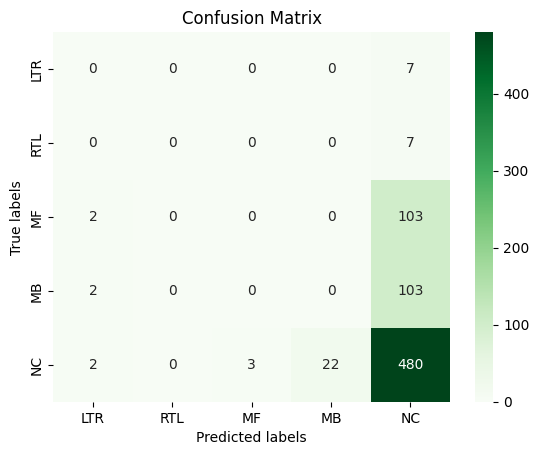

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

ax= plt.subplot()
cm = confusion_matrix(ground_truth, pred, labels=[0,1,2,3,4], normalize=None)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Greens');  #annot=True to annotate cells, ftm='g' to disable scientific notation

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
x_labels=['LTR', 'RTL', 'MF', 'MB', 'NC']
y_labels=x_labels
ax.xaxis.set_ticklabels(x_labels); ax.yaxis.set_ticklabels(y_labels);

In [10]:
sum([1 if p==4 else 0 for p in ground_truth])

507

In [11]:
#not used!!!
raise ValueError

ValueError: ignored

In [ ]:


dataset=[]
graph_list=torch.load(PATH + "/IA_graph_dataset")
for g in graph_list:
  remapped_g = nx.convert_node_labels_to_integers(g) #remaps the ndes (and edges) to format like 0,1,2...N
  d = from_networkx(remapped_g, )
  #hd = d.to_heterogeneous(node_type_names=(["data"]), edge_type_names=[("data","edge","data")])
  # d = from_networkx(g)
  # nx.get_node_attributes(graph_list[0], "xy")
  nodes = remapped_g.nodes()

  #"resets" the node id and removes isolated nodes
  edge_index = d.edge_index
  nodes = torch.unique(edge_index) #removes isolated nodes
  edge_label = d.label

  # node_xy = [int(g.nodes[node]["xy"][0]) for node in g.nodes]
  # node_x, node_y = torch.split(d.xy, split_size_or_sections=1, dim=1)
  node_x = d.xy[:, 0]
  node_y = d.xy[:, 1]


  data = HeteroData()
  edge_label = torch.FloatTensor( [float(i) for i in list(edge_label)])
  data["data"].node_id = torch.IntTensor( [int(i) for i in list(nodes)])

  data["data"].num_nodes = d.num_nodes

  node_features=torch.stack([node_x, node_y]).t()

  data["data"].x = node_features
  data['data', 'edge', 'data'].edge_index = edge_index

  #create it as size edge_label*num_classes
  # use torch_geometric.utils.one_hot() instead does the same thing
  def change_edge_label_dim(edge_label):
    zero_list = lambda n=0: [0. for i in range(n)]
    el=[]
    for label in edge_label:
      temp=zero_list(NUM_EDGE_CLASSES)
      temp[int(label)]=1.0
      el.append(temp)
    return torch.FloatTensor(el)

  data['data', 'edge', 'data'].edge_label = change_edge_label_dim(edge_label)
  # data['data', 'edge', 'data'].edge_label = edge_label

  dataset.append(data)

  # Save node indices:
  '''
  data.node_id = Tensor(list(B.nodes()))

  # Add the node features and edge indices:
  data.x = np.ones(B.number_of_nodes())

  data.edge_index = edge_index
  data.edge_label = edge_label
  data.number_of_nodes =  num_nodes

  '''
  # Add the node features and edge indices:
  #data["data"].x = np.ones(B.number_of_nodes())

# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
#data = T.ToUndirected()(data)

In [ ]:
#generate fake/debugging dataset
# sample_data=dataset[0]
# dataset=[]
# for i in range(1000):
#   dataset.append(sample_data)

In [ ]:
# load graph object from file
#d = pickle.load(open('sampled_data.pickle', 'rb'))

In [ ]:
#try 2
from torch_geometric.nn import GraphConv
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(-1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 9)

    def forward(self, data):

        x, edge_index, batch = data["data"].node_id, data[("data", "edge", "data")].edge_index, data["data"].batch

        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        #x = F.dropout(x, p=0.5, training=self.training)
        x = F.dropout(x, p=0.1, training=self.training)

        x = self.lin(x)

        return x

model = GNN(hidden_channels=64)
print(model)

In [ ]:
#train_dataset

In [ ]:
data.edge_index_dict


In [ ]:
metadata=data.metadata()
names = metadata[0] + [rel for _, rel, _ in metadata[1]]
for name in names:
  print(name)

In [ ]:
 data["edge"].edge_index

In [ ]:
import tqdm
import torch.nn.functional as F
import torch
from torch import Tensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 6):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        sampled_data.to(device)
        pred = model(sampled_data)

        ground_truth = sampled_data["user", "rates", "movie"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

In [ ]:
i=1
#IG[data.edge_index[0][i].item()][2]
print(IG[data.edge_index[0][i].item()+1][data.edge_index[1][i].item()+1])

In [ ]:
data=from_networkx(IG)
print(data.edge_index)
edge_attr=[]
for i in range(len(data.edge_index[0])):
  print([data.edge_index[0][i]+1][0].item())
  t=(IG[data.edge_index[0][i].item()][data.edge_index[1][i].item()])
  print(t)
  edge_attr.append=t
edge_attr
#edge_attr= [IG[] for i in data.edge_index]
#print(edge_attr)


'''
edge_attr[i] corresponds to the edge
between edge_index[0][i] and edge_index[1][i].
'''


In [ ]:
edge_index=[for i in IG.edges()]


In [ ]:
! pip install dgl

# import torch.nn.functional as F

In [ ]:
import dgl
import torch.nn as nn
import numpy as np
import torch
import pandas as pd


In [ ]:
B=nx.read_edgelist(PATH + "/IA_graph.csv", data=True, edgetype=int, nodetype=int, create_using=nx.DiGraph)
nx.write_edgelist(B,PATH+"/IA_graph1.csv",data=["label"], delimiter ="," )


In [ ]:
B.edges(data=True)
d=from_networkx(B)
edge_index = d.edge_index
edge_label = d.label
num_nodes = d.num_nodes


In [ ]:
graph=pd.read_csv(PATH + "/IA_graph1.csv", header=None, names=["src",'dst','label'])
graph

In [ ]:
src = np.random.randint(0, 100, 500)
dst = np.random.randint(0, 100, 500)
# make it symmetric
edge_pred_graph = dgl.graph((np.concatenate([src, dst]), np.concatenate([dst, src])))
# synthetic node and edge features, as well as edge labels
edge_pred_graph.ndata['feature'] = torch.randn(100, 10)
edge_pred_graph.edata['feature'] = torch.randn(1000, 10)
edge_pred_graph.edata['label'] = torch.randn(1000)
# synthetic train-validation-test splits
edge_pred_graph.edata['train_mask'] = torch.zeros(1000, dtype=torch.bool).bernoulli(0.6)

In [ ]:
edge_pred_graph

In [ ]:
B.edges(data=True)

In [ ]:
edge_pred_graph.num_edges()

In [ ]:
B=nx.read_edgelist(PATH + "/IA_graph.csv", data=True, edgetype=int, nodetype=int, create_using=nx.DiGraph)
edge_pred_graph=dgl.from_networkx(B, edge_attrs=["label"])
#edge_pred_graph.edata['label'] = graph.label
# synthetic train-validation-test splits
edge_pred_graph.edata['train_mask'] = torch.zeros(edge_pred_graph.num_edges(), dtype=torch.bool).bernoulli(0.6)
edge_pred_graph.edata['train_mask']


In [ ]:
print(len(graph))
src = graph.src
dst = graph.dst
num_edges=len(graph)
# make it symmetric
edge_pred_graph = dgl.graph((np.concatenate([src, dst]), np.concatenate([dst, src])))
# synthetic node and edge features, as well as edge labels
#edge_pred_graph.ndata['feature'] = torch.randn(100, 10)
# edge_pred_graph.edata['feature'] = graph.label
edge_pred_graph.edata['label'] = graph.label
# synthetic train-validation-test splits
edge_pred_graph.edata['train_mask'] = torch.zeros(edge_pred_graph.num_edges(), dtype=torch.bool).bernoulli(0.6)

In [ ]:
# Contruct a two-layer GNN model
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        print(graph)
        print(inputs)
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h


import dgl.function as fn
class DotProductPredictor(nn.Module):
    def forward(self, graph, h):
        # h contains the node representations computed from the GNN defined
        # in the node classification section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return graph.edata['score']


class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        # h contains the node representations computed from the GNN defined
        # in the node classification section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']


class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.sage = SAGE(in_features, hidden_features, out_features)
        self.pred = DotProductPredictor()
    def forward(self, g, x):
        h = self.sage(g, x)
        return self.pred(g, h)

from torch import Tensor
# node_features = edge_pred_graph.ndata['feature']
edge_label = edge_pred_graph.edata['label']
train_mask = edge_pred_graph.edata['train_mask']
model = Model(1, 20, 10)
opt = torch.optim.Adam(model.parameters())


pred = model(edge_pred_graph, Tensor())
loss = ((pred[train_mask] - edge_label[train_mask]) ** 2).mean()
opt.zero_grad()
loss.backward()
opt.step()
print(loss.item())


# for epoch in range(10):
#     pred = model(edge_pred_graph, Tensor())
#     loss = ((pred[train_mask] - edge_label[train_mask]) ** 2).mean()
#     opt.zero_grad()
#     loss.backward()
#     opt.step()
#     print(loss.item())

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class EdgePredictor(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(EdgePredictor, self).__init__(aggr='max')  # Use max pooling for message aggregation

        self.node_idx = torch.arange(in_channels, dtype=torch.long)
        self.lin = nn.Linear(in_channels * 2, out_channels)

    def forward(self, x, edge_index):
        # x: Node features
        # edge_index: Graph connectivity

        # Add self-loops for the message passing
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Calculate the normalized degree for each node
        deg = degree(edge_index[0], x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        # Calculate the normalized adjacency matrix
        norm = deg_inv_sqrt[edge_index[0]] * deg_inv_sqrt[edge_index[1]]
        edge_index_norm = Tensor((2,200))
        print((edge_index / norm).size())
        print((edge_index).size())
        edge_index_norm = (edge_index / norm).int
        return self.propagate(edge_index=edge_index_norm, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j):
        return x_j

    def update(self, aggr_out, x):
        aggr_out = torch.cat([aggr_out, x[self.node_idx]], dim=-1)
        aggr_out = F.relu(self.lin(aggr_out))
        return aggr_out


# Example usage:
# Initialize the model
model = GNNEdgeClassifier(in_channels=1, hidden_channels=32, out_channels=11)  # 11 classes (0 to 10)

# Example data (replace with your own data)
x = torch.randn(100, 1)  # Node features (not used in this example)
edge_index = torch.randint(0, 100, (2, 200), dtype=torch.long)  # Random edge connectivity
edge_labels = torch.randint(0, 11, (200,), dtype=torch.long)  # Random edge labels (0 to 10)

# Forward pass
predictions = model(x, edge_index)

# Calculate loss (replace with your own loss function)
criterion = nn.CrossEntropyLoss()
loss = criterion(predictions, edge_labels)
